In [78]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pandas as pd
import random

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

In [79]:
path = "/Users/muhammadhussain/Desktop/Data/filter/finished.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [80]:
evaldatatrain = pd.read_parquet(path)
evaldatatrain = evaldatatrain.drop(columns=["main_fault_0", "Type_0", "Event_0"])
evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_23,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber
0,0.473373,0.473373,0.470238,0.464286,0.446429,0.452381,0.440476,0.434524,0.428571,0.416667,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:29:08,Electrical malfunction,806020
1,0.473373,0.467456,0.464286,0.446429,0.452381,0.440476,0.434524,0.428571,0.416667,0.398810,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:30:09,Electrical malfunction,806020
2,0.467456,0.461538,0.446429,0.452381,0.440476,0.434524,0.428571,0.416667,0.398810,0.392857,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:31:08,Electrical malfunction,806020
3,0.461538,0.443787,0.452381,0.440476,0.434524,0.428571,0.416667,0.398810,0.392857,0.398810,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:32:08,Electrical malfunction,806020
4,0.443787,0.449704,0.440476,0.434524,0.428571,0.416667,0.398810,0.392857,0.398810,0.386905,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:33:08,Electrical malfunction,806020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139954,0.378698,0.390533,0.410714,0.434524,0.446429,0.458333,0.452381,0.470238,0.470238,0.470238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:29:12,None,806278
139955,0.390533,0.408284,0.434524,0.446429,0.458333,0.452381,0.470238,0.470238,0.470238,0.464286,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:30:12,None,806278
139956,0.408284,0.431953,0.446429,0.458333,0.452381,0.470238,0.470238,0.470238,0.464286,0.452381,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:31:12,None,806278
139957,0.431953,0.443787,0.458333,0.452381,0.470238,0.470238,0.470238,0.464286,0.452381,0.434524,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:32:12,None,806278


In [81]:
evaldatatrain["main_fault"].unique()

array(['Electrical malfunction', 'Refrigerant leakage',
       '1st stage compressor', 'High condensation (No fix)',
       'Door tightness', 'Wrong setpoint', '2nd stage compressor',
       'Unstable operation (No fix)', 'None'], dtype=object)

In [82]:
# Replace NaN with "None"
evaldatatrain['main_fault'] = evaldatatrain['main_fault'].fillna('None')

# Factorize the column
codes, uniques = pd.factorize(evaldatatrain['main_fault'])

# Ensure "None" is assigned to 0
if 'None' in uniques:
    none_index = list(uniques).index('None')  # Find the index of "None"
    # Swap the code for "None" to 0
    codes = [0 if code == none_index else (code + 1 if code < none_index else code) for code in codes]

# Update the column
evaldatatrain['main_fault_numeric'] = codes

evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber,main_fault_numeric
0,0.473373,0.473373,0.470238,0.464286,0.446429,0.452381,0.440476,0.434524,0.428571,0.416667,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:29:08,Electrical malfunction,806020,1
1,0.473373,0.467456,0.464286,0.446429,0.452381,0.440476,0.434524,0.428571,0.416667,0.398810,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:30:09,Electrical malfunction,806020,1
2,0.467456,0.461538,0.446429,0.452381,0.440476,0.434524,0.428571,0.416667,0.398810,0.392857,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:31:08,Electrical malfunction,806020,1
3,0.461538,0.443787,0.452381,0.440476,0.434524,0.428571,0.416667,0.398810,0.392857,0.398810,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:32:08,Electrical malfunction,806020,1
4,0.443787,0.449704,0.440476,0.434524,0.428571,0.416667,0.398810,0.392857,0.398810,0.386905,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2022-08-19 12:33:08,Electrical malfunction,806020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139954,0.378698,0.390533,0.410714,0.434524,0.446429,0.458333,0.452381,0.470238,0.470238,0.470238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:29:12,None,806278,0
139955,0.390533,0.408284,0.434524,0.446429,0.458333,0.452381,0.470238,0.470238,0.470238,0.464286,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:30:12,None,806278,0
139956,0.408284,0.431953,0.446429,0.458333,0.452381,0.470238,0.470238,0.470238,0.464286,0.452381,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:31:12,None,806278,0
139957,0.431953,0.443787,0.458333,0.452381,0.470238,0.470238,0.470238,0.464286,0.452381,0.434524,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-01 03:32:12,None,806278,0


In [83]:
# Get unique pairs of main_fault and main_fault_numeric
unique_pairs = evaldatatrain[['main_fault', 'main_fault_numeric']].drop_duplicates().sort_values(by='main_fault_numeric')

# Print the mapping
print("Mapping of strings to numbers:")
for index, row in unique_pairs.iterrows():
    print(f"{row['main_fault_numeric']}: {row['main_fault']}")

Mapping of strings to numbers:
0: None
1: Electrical malfunction
2: Refrigerant leakage
3: 1st stage compressor
4: High condensation (No fix)
5: Door tightness
6: Wrong setpoint
7: 2nd stage compressor
8: Unstable operation (No fix)


In [84]:
evaldatatrain["main_fault_numeric"].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 0])

In [85]:
from sklearn.model_selection import train_test_split
import torch

# Definer input og output
inp = evaldatatrain.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"])
time = evaldatatrain["Datetime"]
out = evaldatatrain["main_fault_numeric"]
seriesnumber = evaldatatrain["seriesnumber"]

# Split data i train, valid og test (40%, 40%, 20%)
x_temp, x_test, y_temp, y_test, time_temp, time_test, series_temp, series_test = train_test_split(
    inp, out, time, seriesnumber, test_size=0.2, stratify=out, random_state=42
)

x_train, x_valid, y_train, y_valid, time_train, time_valid, series_train, series_valid = train_test_split(
    x_temp, y_temp, time_temp, series_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Konverter til PyTorch tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
x_test = torch.tensor(x_test.values, dtype=torch.float32)

targets_train = torch.tensor(y_train.values, dtype=torch.int64)
targets_valid = torch.tensor(y_valid.values, dtype=torch.int64)
targets_test = torch.tensor(y_test.values, dtype=torch.int64)

# Lav også tids- og seriesnummerlister for senere analyse
time_train = time_train.reset_index(drop=True)
time_valid = time_valid.reset_index(drop=True)
time_test = time_test.reset_index(drop=True)

series_train = series_train.reset_index(drop=True)
series_valid = series_valid.reset_index(drop=True)
series_test = series_test.reset_index(drop=True)

# Bekræft fordelingen med pandas value_counts()
print("Train target distribution:", y_train.value_counts().to_dict())
print("Valid target distribution:", y_valid.value_counts().to_dict())
print("Test target distribution:", y_test.value_counts().to_dict())


Train target distribution: {3: 13656, 8: 6816, 1: 6815, 5: 6771, 2: 5645, 0: 5089, 7: 4385, 4: 3421, 6: 3385}
Valid target distribution: {3: 13656, 8: 6816, 1: 6815, 5: 6772, 2: 5646, 0: 5089, 7: 4384, 4: 3421, 6: 3385}
Test target distribution: {3: 6828, 8: 3408, 1: 3408, 5: 3386, 2: 2823, 0: 2545, 7: 2192, 4: 1710, 6: 1692}


In [86]:
# To speed up training we'll only work on a subset of the data
#x_train = inp[:round(len(inp)/3)]
#targets_train = out[:round(len(inp)/3)]

#x_valid = inp[round(len(inp)/3):round(2*len(inp)/3)]
#targets_valid = out[round(len(inp)/3):round(2*len(inp)/3)]

#x_test = inp[round(2*len(inp)/3):]
#targets_test = out[round(2*len(inp)/3):]

#from sklearn.model_selection import train_test_split
#import torch

#x_train = inp[:1000]
#targets_train = out[:1000]

#x_valid = inp[1000:2000]
#targets_valid = out[1000:2000]

#x_test = inp[2000:3000]
#targets_test = out[2000:3000]


print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([55983, 360])
targets_train torch.Size([55983])
x_valid torch.Size([55984, 360])
targets_valid torch.Size([55984])
x_test torch.Size([27992, 360])
targets_test torch.Size([27992])


In [87]:
# Hyperparameters
num_classes = 9 
num_l1 = 32  # Increased size of the first hidden layer
num_l2 = 16  # Added a second hidden layer
num_l3 = 8   # Added a third hidden layer
num_features = x_train.shape[1]

# Define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_hidden3, num_output):
        super(Net, self).__init__()  
        # Input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # BatchNorm for input layer
        self.norm1 = nn.BatchNorm1d(num_features=num_hidden1)
        
        # Hidden layer 1
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))
        # BatchNorm for hidden layer 1
        self.norm2 = nn.BatchNorm1d(num_features=num_hidden2)

        # Hidden layer 2
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden3, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_hidden3), 0))
        # BatchNorm for hidden layer 2
        self.norm3 = nn.BatchNorm1d(num_features=num_hidden3)

        # Output layer
        self.W_4 = Parameter(init.kaiming_uniform_(torch.Tensor(num_output, num_hidden3)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))

        # Dropout layer
        self.dropout = nn.Dropout(0.3)  # Increased dropout rate to prevent overfitting

        # Activation function
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        # Input layer
        x = self.dropout(x)
        x = F.linear(x, self.W_1, self.b_1)
        x = self.norm1(x)
        x = self.activation(x)

        # Hidden layer 1
        x = self.dropout(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.norm2(x)
        x = self.activation(x)

        # Hidden layer 2
        x = self.dropout(x)
        x = F.linear(x, self.W_3, self.b_3)
        x = self.norm3(x)
        x = self.activation(x)

        # Output layer
        x = F.linear(x, self.W_4, self.b_4)
        
        return x

# Initialize the network
net = Net(num_features, num_l1, num_l2, num_l3, num_classes)


In [88]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 3.045396 , Train acc 0.821180, Valid acc 0.821126
Epoch 11 : Train Loss 3.038365 , Train acc 0.824772, Valid acc 0.822770
Epoch 21 : Train Loss 3.046638 , Train acc 0.807900, Valid acc 0.807757
Epoch 31 : Train Loss 3.030189 , Train acc 0.787811, Valid acc 0.788150
Epoch 41 : Train Loss 3.055394 , Train acc 0.761609, Valid acc 0.760697
Epoch 51 : Train Loss 3.047841 , Train acc 0.766023, Valid acc 0.765666
Epoch 61 : Train Loss 3.034595 , Train acc 0.742985, Valid acc 0.741769
Epoch 71 : Train Loss 3.051564 , Train acc 0.800536, Valid acc 0.799929
Epoch 81 : Train Loss 3.037225 , Train acc 0.818159, Valid acc 0.819374
Epoch 91 : Train Loss 3.055360 , Train acc 0.817105, Valid acc 0.815121
Model saved to trained_modelFFNN.pth


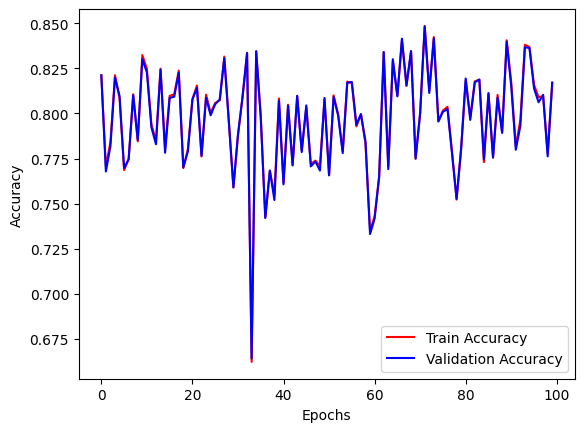

In [100]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import matplotlib.pyplot as plt

# setting hyperparameters and getting epoch sizes
batch_size = 150
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprop -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

# Save the model's parameters
model_path = "trained_modelFFNN.pth"
torch.save(net.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot accuracy
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs'), plt.ylabel('Accuracy')
plt.show()


In [101]:
print(y_train.value_counts(normalize=True))
print(y_valid.value_counts(normalize=True))

main_fault_numeric
3    0.243931
8    0.121751
1    0.121733
5    0.120947
2    0.100834
0    0.090903
7    0.078327
4    0.061108
6    0.060465
Name: proportion, dtype: float64
main_fault_numeric
3    0.243927
8    0.121749
1    0.121731
5    0.120963
2    0.100850
0    0.090901
7    0.078308
4    0.061107
6    0.060464
Name: proportion, dtype: float64


In [102]:
# Indlæs modellen
num_classes = 9 
num_l1 = 32  # Increased size of the first hidden layer
num_l2 = 16  # Added a second hidden layer
num_l3 = 8   # Added a third hidden layer
num_features = x_train.shape[1]


net_loaded = Net(num_features, num_l1,num_l2,num_l3  ,num_classes)  # Sørg for at bruge samme arkitektur
net_loaded.load_state_dict(torch.load(model_path))
net_loaded.eval()  # Sæt modellen i evalueringsmodus

print("Model loaded successfully!")


Model loaded successfully!


In [103]:
net.eval()

Net(
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): ReLU()
)

In [104]:
output = net(x_test)
output

tensor([[-1.3655e+00, -2.9022e-01,  7.7976e-01,  ..., -1.2874e+00,
          3.2920e-01,  3.3861e+00],
        [ 6.3921e-01, -9.6463e-01, -2.7106e+00,  ..., -1.9767e+00,
         -7.5974e-01, -1.1644e+00],
        [-5.8889e-01, -9.2497e-01, -1.5909e+00,  ..., -5.2091e-01,
         -2.9764e-02, -1.9904e-01],
        ...,
        [ 2.9127e+00, -2.2387e+00,  6.2345e-01,  ..., -8.7124e-01,
         -1.6205e+00, -3.3527e-01],
        [-1.5509e-02, -6.8315e-04, -1.1022e+00,  ...,  3.7437e+00,
         -7.3383e-01, -1.2410e+00],
        [-9.2254e-01, -4.4754e-01, -1.2060e+00,  ..., -5.4158e-01,
          7.5440e-02, -1.3486e-02]], grad_fn=<AddmmBackward0>)

In [105]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

tensor([8, 5, 3,  ..., 0, 6, 3])

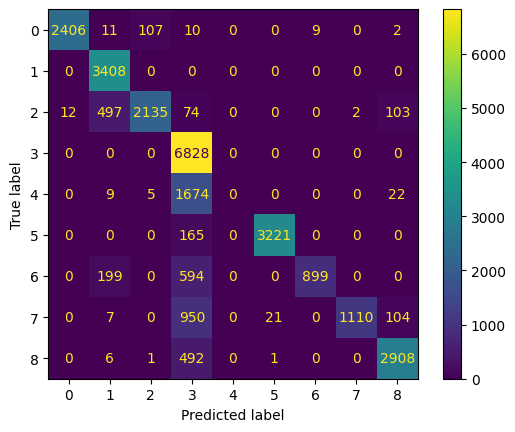

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_test), dim=1)

cm = confusion_matrix(targets_test, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [111]:
targets_test.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [112]:
predictedclass.unique()

tensor([0, 1, 2, 3, 5, 6, 7, 8])

In [107]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_test]

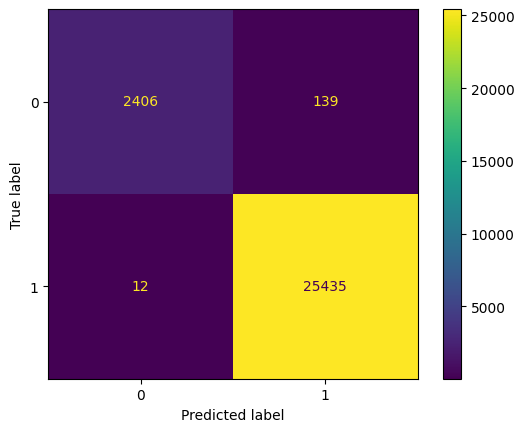

In [108]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()

In [98]:
unique_values, counts = torch.unique(targets_train, return_counts=True)

print("Unikke værdier:", unique_values)
print("Hyppigheder:", counts)

Unikke værdier: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Hyppigheder: tensor([ 5089,  6815,  5645, 13656,  3421,  6771,  3385,  4385,  6816])


Test model for unseen data.

In [ ]:
path = "/Users/muhammadhussain/Desktop/Data/filter/finished.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [ ]:
evaldatatrain = pd.read_parquet(path)
evaldatatrain = evaldatatrain.drop(columns=["main_fault_0", "Type_0", "Event_0"])
evaldatatrain

In [ ]:
evaldatatrain["main_fault"].unique()

In [ ]:
# Replace NaN with "None"
evaldatatrain['main_fault'] = evaldatatrain['main_fault'].fillna('None')

# Factorize the column
codes, uniques = pd.factorize(evaldatatrain['main_fault'])

# Ensure "None" is assigned to 0
if 'None' in uniques:
    none_index = list(uniques).index('None')  # Find the index of "None"
    # Swap the code for "None" to 0
    codes = [0 if code == none_index else (code + 1 if code < none_index else code) for code in codes]

# Update the column
evaldatatrain['main_fault_numeric'] = codes

evaldatatrain

In [ ]:
# Get unique pairs of main_fault and main_fault_numeric
unique_pairs = evaldatatrain[['main_fault', 'main_fault_numeric']].drop_duplicates().sort_values(by='main_fault_numeric')

# Print the mapping
print("Mapping of strings to numbers:")
for index, row in unique_pairs.iterrows():
    print(f"{row['main_fault_numeric']}: {row['main_fault']}")

In [ ]:
output = net(x_test)
output

In [ ]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_test), dim=1)

cm = confusion_matrix(targets_test, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_test]

In [ ]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()